# Test validity step 2 : $P(s_c | ...) \propto (s_c - s_{c,WF})^t (C^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) (s_c - s_{c,WF})$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro.distributions as dist
import lineax as lx
from lanczos_test import *

import micmac as micmac

In [2]:
PRNGKey = random.PRNGKey(0)


In [3]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [4]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


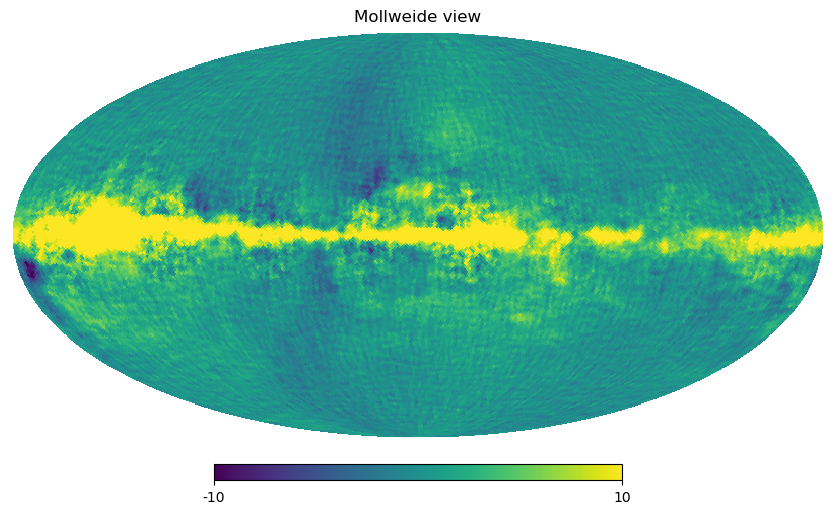

In [5]:
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, n_pix

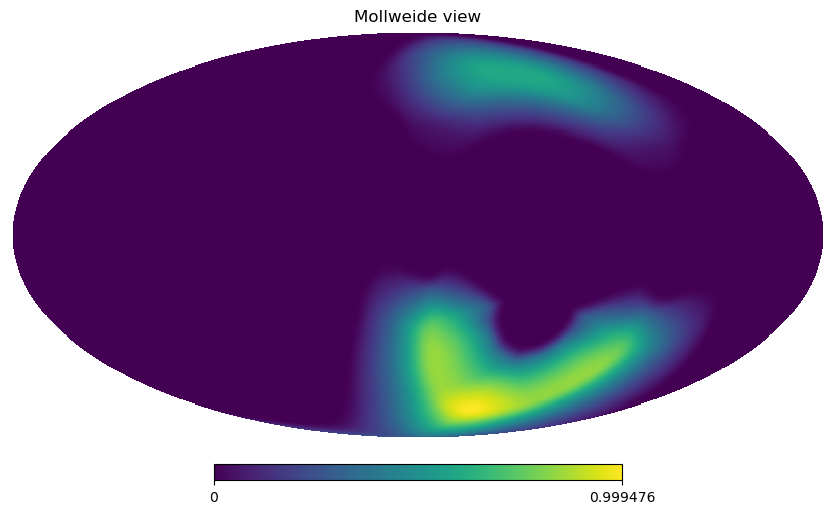

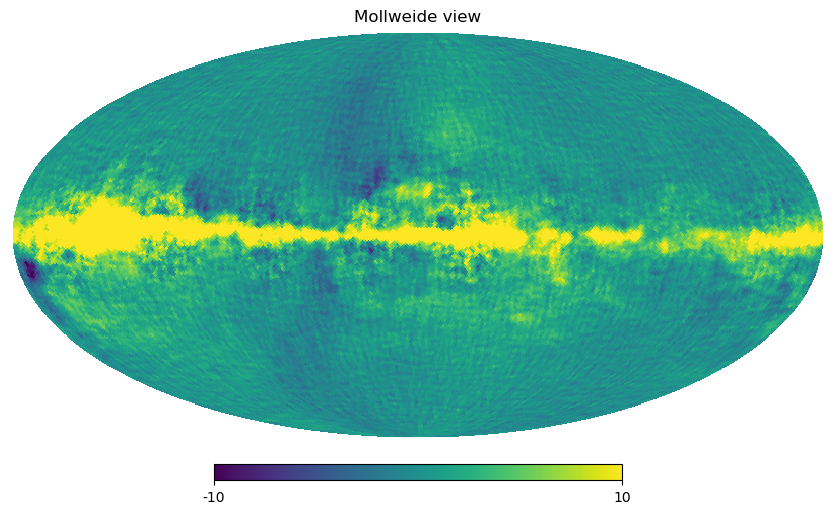

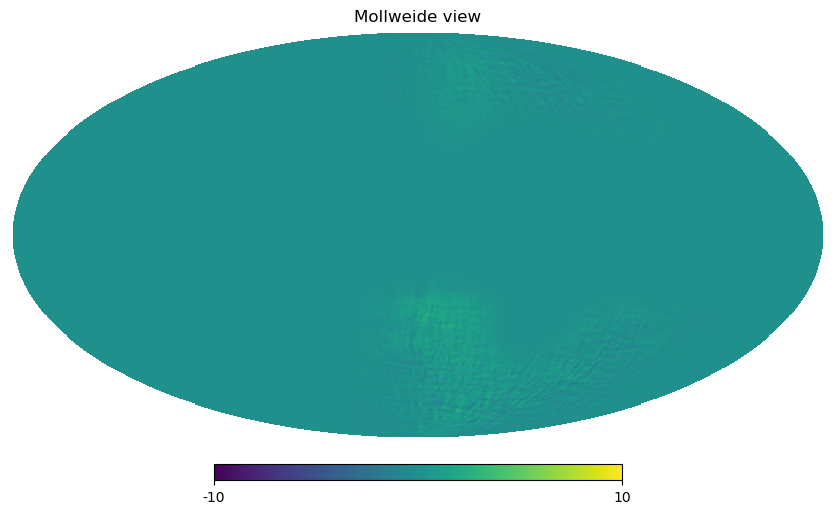

In [6]:
path_mask_test = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

mask_test = hp.read_map(path_mask_test)
hp.mollview(mask_test)
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, n_pixhp.mollview(freq_maps[0,0]) # Freq, nstokes, n_pix
hp.mollview(freq_maps[2,0]*hp.ud_grade(mask_test,nside_out=64), min=-10, max=10) # Freq, nstokes, n_pix

In [7]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_spatialvariability_v2/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'main_params/'


path_toml_file = directory_toml_file + 'corr_fullsky_SO_v2b.toml'


In [8]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

No spatial variability case



>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [0]
    f0
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
    f1
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None

>>> Tree of spv config after filling the missing values:
root
  nside_spv
    default: [0]
    f0
      default: [0]
      b0
        default: [0]
      b1
        default: [0]
      b2
        default: [0]
      b3
        default: [0]
    f1
      default: [0]
      b0
        default: [0]
      b1
        default: [0]
      b2
        default: [0]
      b3
        default: [0]


In [9]:
reduction_noise = 1

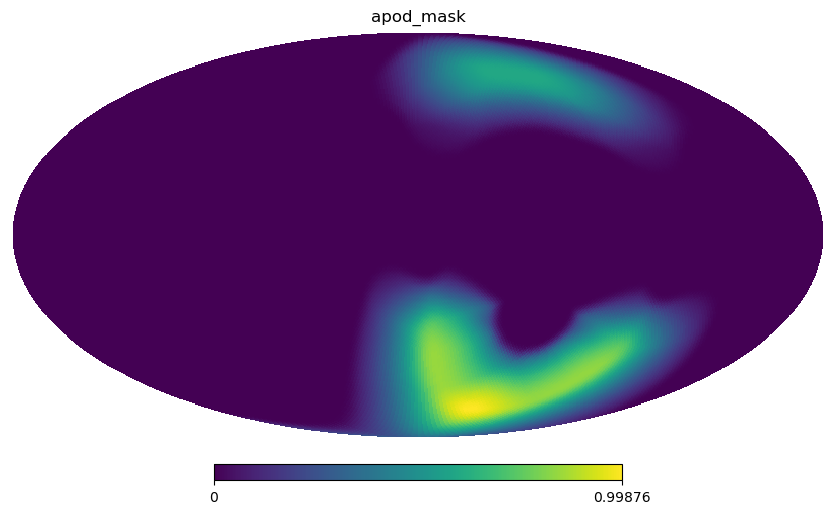

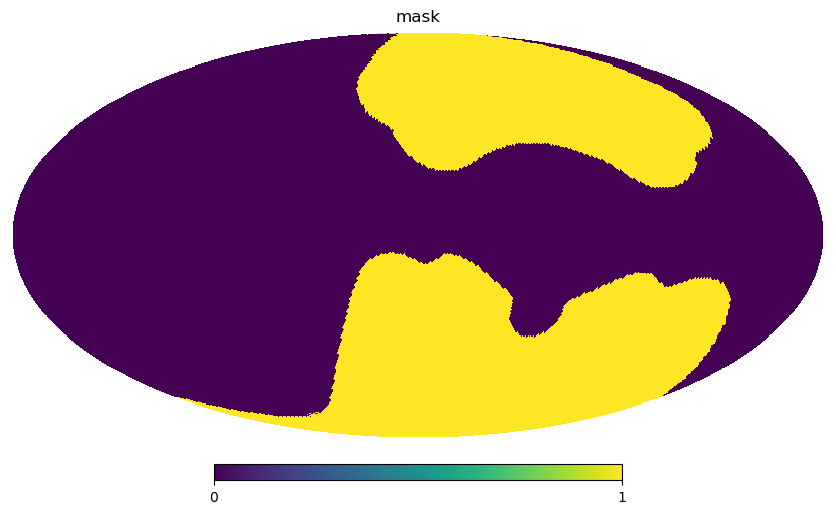

In [10]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

relative_treshold = 1e-1

apod_mask = hp.ud_grade(hp.read_map(path_mask_test),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)

mask[apod_mask>0] = 1

hp.mollview(apod_mask, title='apod_mask')

hp.mollview(mask, title='mask')


In [11]:
mask = np.ones(MICMAC_sampler_obj.n_pix)

MICMAC_sampler_obj.mask = np.array(mask)

In [12]:
# freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)
freq_inverse_noise_0 = micmac.get_noise_covar(instrument['depth_p'], MICMAC_sampler_obj.nside) #MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_pix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise_0.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_frequencies,nb_pixels_mask), order='C')

freq_inverse_noise_masked = freq_inverse_noise_masked*mask
# freq_inverse_noise_masked = freq_inverse_noise_masked*nhits_mask

MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked
freq_inverse_noise = freq_inverse_noise_masked

In [13]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps

np.random.seed(noise_seed)
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=True)[:, 1:, :]   # keep only Q and U

In [14]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [15]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.n_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs, spv_nodes_b=MICMAC_sampler_obj.spv_nodes_b)
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], n_components=MICMAC_sampler_obj.n_components, params=init_params, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs, spv_nodes_b=MICMAC_sampler_obj.spv_nodes_b, nside=MICMAC_sampler_obj.nside)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)#*mask
# BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)#*mask
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)#*mask

BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)#*mask

nb_pix_mask = int(np.sum(mask))


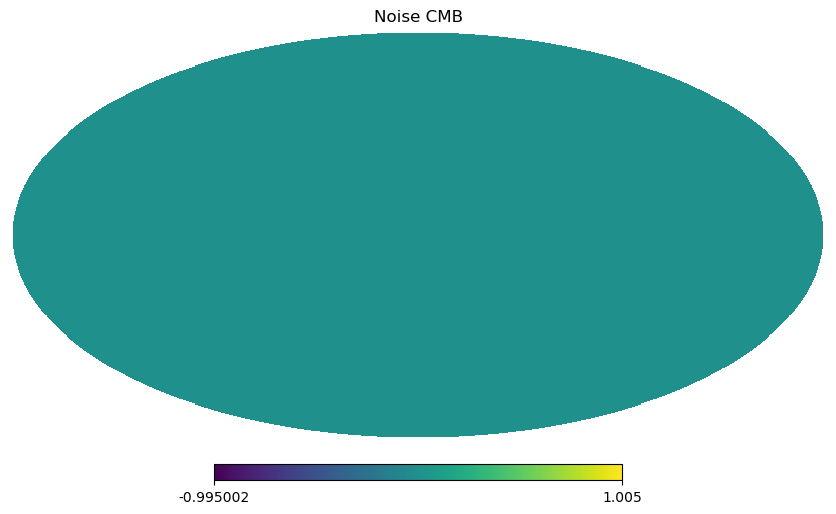

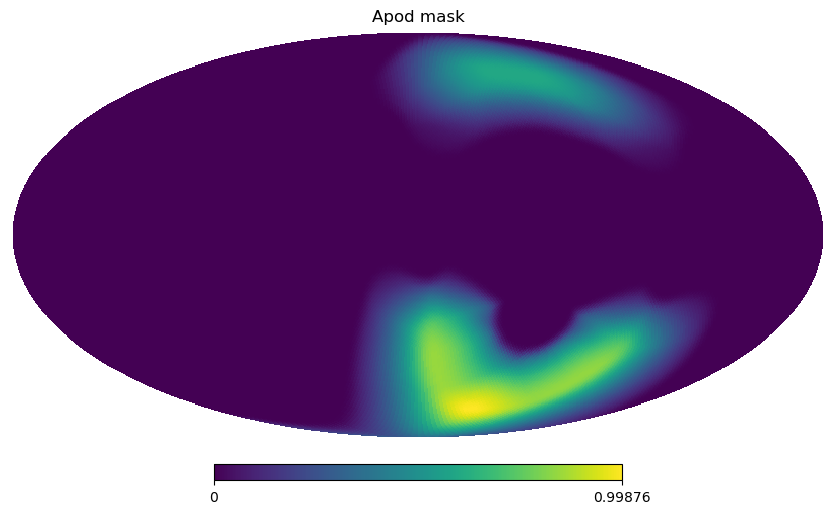

In [16]:
hp.mollview(BtinvNB[0,0], title='Noise CMB')
hp.mollview(apod_mask, title='Apod mask')

In [17]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask
input_cmb_maps = input_cmb_maps*mask

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [18]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps_masked, jax_use=False)[0, :, :]

In [19]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [20]:
n_frequencies = MICMAC_sampler_obj.n_frequencies
n_components = MICMAC_sampler_obj.n_components
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter
n_pix = 12*nside**2

In [21]:
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/BtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), MICMAC_sampler_obj.nstokes).reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix), order='F').ravel()

def second_term_left(x):
    return x*N_c_inv_repeat

red_cov_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_cov_matrix_sample)
first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), red_cov_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

func = lambda x: x.ravel() + first_part_term_left(second_term_left(first_part_term_left(x)))

right_member = maps_x_red_covariance_cell_JAX(s_cML*N_c_inv, red_cov_matrix_sqrt, nside=nside, lmin=lmin, n_iter=n_iter).ravel()

In [22]:
noise_c_ell = micmac.get_Cl_noise_JAX(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0]

red_inv_noise_c_ell = jnp.linalg.pinv(micmac.get_reduced_matrix_from_c_ell_jax(jnp.stack([noise_c_ell, noise_c_ell, jnp.zeros_like(noise_c_ell)])))[lmin:]

red_solution = jnp.linalg.pinv(jnp.eye(nstokes) + jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell, red_cov_matrix_sqrt))

precond_test = lambda x: maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), red_solution, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

In [23]:
freq_inv_noise_cell = micmac.get_Cl_noise_JAX(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)

test_freq_noise_cell = get_true_Cl_noise(np.array(instrument['depth_p']), lmax)
noise_c_ell_b = get_inv_BtinvNB_c_ell(test_freq_noise_cell, mixing_matrix_sampled.mean(axis=2))


# Putting in place Lanczos

In [24]:
test_func_Lanczos = lambda x: 2*jnp.arange(1,2*MICMAC_sampler_obj.n_pix+1)*x

In [128]:
max_number_iter = 1000

In [129]:
%%time
# all_alphas, all_betas, all_eigenvectors, all_matvec_to_store = lanczos_algorithm_JAX(test_func_Lanczos, right_member.ravel(), initial_guess=None, max_iter=1000)
all_alphas, all_betas, all_eigenvectors, all_matvec_to_store = lanczos_algorithm_JAX(func, right_member.ravel(), initial_guess=None, max_iter=max_number_iter)

CPU times: user 4min 12s, sys: 27.1 s, total: 4min 39s
Wall time: 44.4 s


In [130]:
all_alphas.shape, all_betas.shape, all_eigenvectors.shape, all_matvec_to_store.shape

((1000,), (1000,), (1000, 98304), (1000, 98304))

In [131]:
tridiag_matrix = jnp.diag(all_alphas) + jnp.diag(all_betas[1:], k=1) + jnp.diag(all_betas[1:], k=-1)
eigvals_tridiag, eigvects_tridiag = jnp.linalg.eigh(tridiag_matrix)

proportion_best_conditioned = max_number_iter#//3
best_conditionned = jnp.argpartition(eigvals_tridiag, -proportion_best_conditioned)[-proportion_best_conditioned:]
print(best_conditionned.shape)

(1000,)


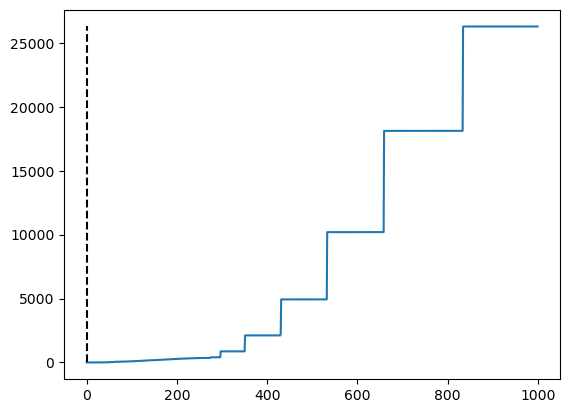

In [132]:
plt.plot(eigvals_tridiag)
plt.plot([max_number_iter-best_conditionned.shape[0], max_number_iter-best_conditionned.shape[0]], [0, eigvals_tridiag.max()], 'k--')
plt.show()

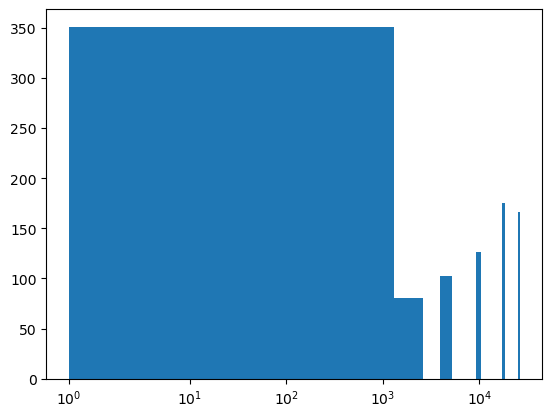

In [133]:
plt.hist(eigvals_tridiag, bins='rice')
plt.xscale('symlog')
plt.show()

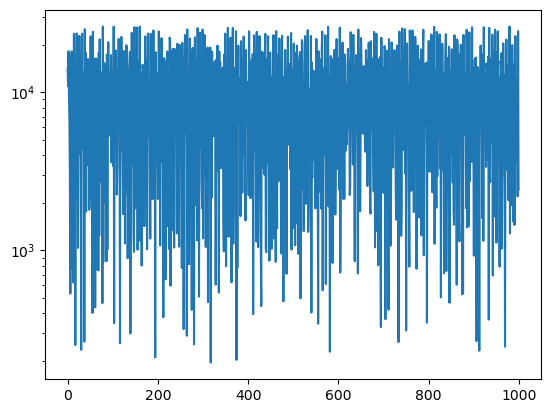

In [134]:
plt.plot(all_alphas)
plt.yscale('log')
plt.show()

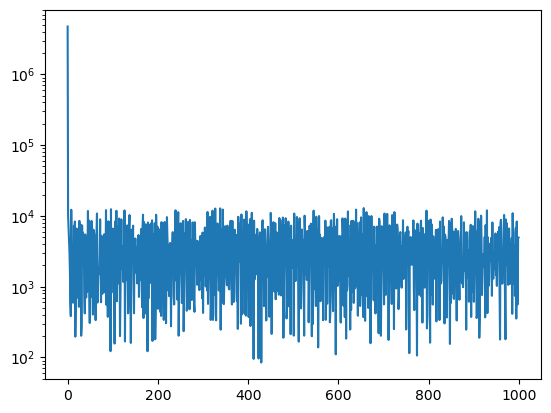

In [135]:
plt.plot(all_betas)
plt.yscale('log')
plt.show()

In [103]:
# diff = np.abs((all_matvec_to_store/N_c_inv_repeat - all_eigenvectors)/all_eigenvectors)
diff = np.abs((all_matvec_to_store - (all_eigenvectors.T*eigvals_tridiag).T)/all_eigenvectors)
# cond = all_eigenvectors != 0
cond = eigvals_tridiag > 5*10**3
diff[cond].max(), diff[cond].min(), diff[cond].mean()

(13060622939.965824, 0.0018987859739773385, 64485.877156575494)

In [104]:
print(eigvals_tridiag[cond].shape, all_eigenvectors[cond].shape)

(46,) (46, 98304)


In [136]:
test_1 = jnp.einsum('ij,ik->jk', all_eigenvectors, tridiag_matrix)
test_2 = all_matvec_to_store.T

In [137]:
jnp.abs(test_1-test_2).max(), jnp.abs(test_1-test_2).mean(), jnp.abs(test_1-test_2).min()

(Array(14.01693672, dtype=float64),
 Array(0.00351935, dtype=float64),
 Array(0., dtype=float64))

In [138]:
jnp.abs(test_1-test_2)[:,:-1].max(), jnp.abs(test_1-test_2)[:,:-1].mean(), jnp.abs(test_1-test_2)[:,:-1].min()

(Array(5.68434189e-14, dtype=float64),
 Array(1.02226557e-15, dtype=float64),
 Array(0., dtype=float64))

In [139]:
jnp.abs(test_1-test_2).T[:-1].mean(axis=1)#.shape

Array([7.58543008e-16, 1.77807487e-15, 1.78561419e-15, 1.04048471e-15,
       7.06067189e-16, 2.95191141e-16, 9.47623442e-17, 2.06422112e-15,
       1.83431663e-15, 8.39082440e-16, 2.68225382e-16, 5.11980391e-16,
       2.44216592e-16, 1.23499389e-15, 1.79197197e-15, 1.23637214e-15,
       1.28008355e-15, 8.22726725e-17, 7.40055209e-16, 1.24185161e-15,
       1.77307153e-15, 5.99366238e-16, 9.62006762e-16, 2.92584458e-16,
       3.71564658e-16, 1.17147255e-15, 1.89266691e-15, 9.29861505e-16,
       1.30259626e-15, 1.23670907e-15, 5.09958593e-17, 1.06324126e-15,
       1.78859107e-15, 1.10127401e-15, 1.55169733e-15, 9.27805215e-16,
       7.24949292e-16, 7.84718410e-17, 1.17368925e-15, 5.63691444e-16,
       7.72181184e-16, 5.42561159e-16, 7.51823956e-16, 5.58596267e-16,
       2.19803999e-15, 1.74550457e-15, 1.55829058e-15, 9.73188384e-16,
       1.79447593e-16, 6.71905308e-16, 1.69593868e-15, 1.74794410e-15,
       1.30364529e-15, 1.27288119e-15, 3.17277506e-16, 9.34917115e-17,
      

In [33]:
all_eigenvectors.shape

(1001, 98304)

In [34]:
test_eigenvector_tridiag = np.copy(eigvects_tridiag)#[idx_test]

test_eigvect_V = jnp.einsum('ji,jk->ik', all_eigenvectors, test_eigenvector_tridiag)

In [35]:
idx_test = 0
test_eigvect_V_2 = test_func_Lanczos(test_eigvect_V[:,idx_test])

corresponding_eigenvalue = eigvals_tridiag[idx_test]

In [36]:
diff = np.abs(test_eigvect_V_2 - corresponding_eigenvalue*test_eigvect_V[:,idx_test])

diff.max(), diff.mean()

(55.26290262258379, 1.0933988843119289)